In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pickle, os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pretty_midi
import json

In [5]:
plt.style.use('ggplot')

# track separation


## the track_separate.py can find melody, bass, chord, accompiment and drum tracks. 


The track separation model is a random forest trained each for melody, bass, chord and drum.

The accompaniment track is found based on the duration of the track, and it selects the longest duration in the left tracks.


the parameters includes:
-f input file
-i input folder (will search all the midi file in that folder)
The user need to specify one of the above two parameters 
-o output folder
-t required tracks to be found. It will always try to find melody, bass, chord, accompaniment and drum tracks, and -t specifies the mandatory tracks. e.g. "melody bass chord" means melody, bass and chord tracks are mandatory for the output. If it cannot find those tracks that file will be omitted. But if the accomaniment and drum are not found and melody, bass, chord are found that file will still be output. The default is "melody", which means only the melody is mandatory for the output.




### example of track_separate.py

read in the original file

In [6]:
original_file = 'example/input/55269aebbc2e7784ca2d1d4472141889.mid'
original_pm = pretty_midi.PrettyMIDI(original_file)
print(f'the original file has {len(original_pm.instruments)} tracks')

the original file has 4 tracks


In [7]:
!python3 track_separate.py -h

usage: track_separate.py [-h] [-i INPUT_FOLDER] [-f FILE_NAME]
                         [-o OUTPUT_FOLDER] [-t REQUIRED_TRACKS]

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT_FOLDER, --input_folder INPUT_FOLDER
                        MIDI file input folder
  -f FILE_NAME, --file_name FILE_NAME
                        input MIDI file name
  -o OUTPUT_FOLDER, --output_folder OUTPUT_FOLDER
                        MIDI file output folder
  -t REQUIRED_TRACKS, --required_tracks REQUIRED_TRACKS
                        output file criteria, a list of name for output
                        tracks,the list can be
                        'melody','bass','chord','accomaniment','drum'


In [8]:
!python3 track_separate.py -f example/input/55269aebbc2e7784ca2d1d4472141889.mid -o example/output/ -t "melody bass chord"

2022-01-17 15:08:35 shl-ws __main__[9506] INFO total file 1
2022-01-17 15:08:36 shl-ws __main__[9506] INFO result file 1
2022-01-17 15:08:36 shl-ws __main__[9506] INFO ratio = 1.0


The output file is in the example/output/ folder

In [9]:
output_file = 'example/output/55269aebbc2e7784ca2d1d4472141889.mid'
output_pm = pretty_midi.PrettyMIDI(output_file)
print(f'the output file has {len(output_pm.instruments)} tracks')

the output file has 4 tracks


the program_result.json has record of the program number of each track

In [10]:
with open(os.path.join('example/output','program_result.json'), 'r') as fp:
    programs = json.load(fp)

In [11]:
for key in programs.keys():
    for name,value in programs[key].items():
        print(f'{name} program number is {value}')
        

melody program number is 75
bass program number is 35
chord program number is 49
accompaniment program number is 25


# tension calculation

The tension calculation is based on the spiral array theory (https://dspace.mit.edu/handle/1721.1/9139,
https://qmro.qmul.ac.uk/xmlui/bitstream/handle/123456789/11798/Herremans%20Tension%20ribbons%20Quantifying%202016%20Accepted.pdf?sequence=1) 


It maps the pitch to a 3-dim position in spiral array space, and keeps property in that space such as dist(perfect fifth) has shortest space in all the interval pairs.

In [12]:
from tension_calculation import *

all the interval distance to C note in a scale

the vertical step is a parameter to set the note position in the 3d space
the original paper uses math.sqrt(2/15) which makes the interval distance of a major third equals a perfect fifth distance
Any value from math.sqrt(2/15) to math.sqrt(0.2) can work according to the original paper
Here 0.4 is used to make the perfect fifth has the shortest distance


## some properties of the distance in the spiral array space

In [13]:
note_to_note_diff = note_to_note_pos([0,1,2,3,4,5,6,7,8,9,10,11],pitch_index_to_position(note_index_to_pitch_index[0]))

use ['C','D-','D','E-','E','F','F#','G','A-','A','B-','B'] to map the note to pitch names

In [14]:
pitch_names = ['C','D-','D','E-','E','F','F#','G','A-','A','B-','B']

In [15]:
for num, pitch_name in enumerate(pitch_names):
    print(f'the distance from {pitch_name} to C is {note_to_note_diff[num]}')

the distance from C to C is 0.0
the distance from D- to C is 2.449489742783178
the distance from D to C is 2.154065922853802
the distance from E- to C is 1.854723699099141
the distance from E to C is 1.6
the distance from F to C is 1.469693845669907
the distance from F# to C is 3.124099870362662
the distance from G to C is 1.469693845669907
the distance from A- to C is 1.6
the distance from A to C is 1.854723699099141
the distance from B- to C is 2.154065922853802
the distance from B to C is 2.449489742783178


In [16]:
note_to_key_diff = note_to_key_pos([0,1,2,3,4,5,6,7,8,9,10,11],major_key_position(0))

In [17]:
for num, pitch_name in enumerate(pitch_names):
    print(f'the distance from {pitch_name} to key pos major C  is {note_to_key_diff[num]}')

the distance from C to key pos major C  is 0.8031142418759614
the distance from D- to key pos major C  is 2.7534938687972415
the distance from D to key pos major C  is 1.426167060867695
the distance from E- to key pos major C  is 1.8640859651593327
the distance from E to key pos major C  is 1.3318980762445751
the distance from F to key pos major C  is 1.5200948935852658
the distance from F# to key pos major C  is 3.164811603477212
the distance from G to key pos major C  is 0.8739430676560115
the distance from A- to key pos major C  is 2.1531447897213045
the distance from A to key pos major C  is 1.4695742531440867
the distance from B- to key pos major C  is 1.8614490284463876
the distance from B to key pos major C  is 1.7812176973924325


In [18]:
note_to_key_diff = note_to_key_pos([0,1,2,3,4,5,6,7,8,9,10,11],minor_key_position(3))

In [19]:
for num, pitch_name in enumerate(pitch_names):
    print(f'the distance from {pitch_name} to key pos minor a  is {note_to_key_diff[num]}')

the distance from C to key pos minor a  is 1.4480262306740166
the distance from D- to key pos minor a  is 3.344664402405718
the distance from D to key pos minor a  is 1.4255168763364396
the distance from E- to key pos minor a  is 2.782169363054665
the distance from E to key pos minor a  is 0.8108222769016649
the distance from F to key pos minor a  is 1.8295990721248196
the distance from F# to key pos minor a  is 3.8924019274376076
the distance from G to key pos minor a  is 1.5687954502483745
the distance from A- to key pos minor a  is 2.942129698827025
the distance from A to key pos minor a  is 0.7925184948756716
the distance from B- to key pos minor a  is 2.4559001536544605
the distance from B to key pos minor a  is 1.5171591758019327


In [20]:
chord_to_key_diff = chord_to_key_pos([0,1,2,3,4,5,6,7,8,9,10,11],major_key_position(0))

In [21]:
chord_names = ['CM','D-M','DM','E-M','EM','FM','F#M','G-M','A-M','AM','B-M','BM',
              'Cm','D-m','Dm','E-m','Em','Fm','F#m','G-m','A-m','Am','B-m','Bm']

In [22]:
for num, pitch_name in enumerate(chord_names):
    print(f'the distance from chord pos {chord_names[num]} to  major C key pos is {chord_to_key_diff[num]}')

the distance from chord pos CM to  major C key pos is 0.3674488556302768
the distance from chord pos D-M to  major C key pos is 2.2396622829132076
the distance from chord pos DM to  major C key pos is 1.4185459278796724
the distance from chord pos E-M to  major C key pos is 1.483241069248017
the distance from chord pos EM to  major C key pos is 1.608570378163169
the distance from chord pos FM to  major C key pos is 1.0337152129595464
the distance from chord pos F#M to  major C key pos is 2.7105926565059533
the distance from chord pos G-M to  major C key pos is 0.9013789821734252
the distance from chord pos A-M to  major C key pos is 1.6740784514185711
the distance from chord pos AM to  major C key pos is 1.4970127392590888
the distance from chord pos B-M to  major C key pos is 1.4559507373204632
the distance from chord pos BM to  major C key pos is 2.131892133646541
the distance from chord pos Cm to  major C key pos is 0.6437207636110552
the distance from chord pos D-m to  major C key 

In [23]:
key_to_key_diff = key_to_key_pos([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], major_key_position(0))

In [24]:
for num, pitch_name in enumerate(chord_names):
    print(f'the distance from key pos {chord_names[num]} to  major C key pos is {key_to_key_diff[num]}')

the distance from key pos CM to  major C key pos is 0.0
the distance from key pos D-M to  major C key pos is 2.0867413090769067
the distance from key pos DM to  major C key pos is 1.1614553723738164
the distance from key pos E-M to  major C key pos is 1.339585492235565
the distance from key pos EM to  major C key pos is 1.6000000000000005
the distance from key pos FM to  major C key pos is 0.7172790886454171
the distance from key pos F#M to  major C key pos is 2.543418680047782
the distance from key pos G-M to  major C key pos is 0.7172790886454171
the distance from key pos A-M to  major C key pos is 1.6000000000000003
the distance from key pos AM to  major C key pos is 1.339585492235565
the distance from key pos B-M to  major C key pos is 1.1614553723738164
the distance from key pos BM to  major C key pos is 2.0867413090769067
the distance from key pos Cm to  major C key pos is 0.42316436241252653
the distance from key pos D-m to  major C key pos is 2.4465731333732905
the distance fro

## calculate the tension by tension_calculation.py

In [25]:
def draw_tension(time,values):
    fig = plt.figure(figsize=(20, 10))
    plt.rcParams['xtick.labelsize'] = 14
    plt.plot(time,values,marker='o')
    plt.tight_layout()
    plt.show()
   
  
    

three tension measures are calculated including tensile strain, cloud diameter and centroid difference (https://qmro.qmul.ac.uk/xmlui/bitstream/handle/123456789/11798/Herremans%20Tension%20ribbons%20Quantifying%202016%20Accepted.pdf?sequence=1)


To calculate those measures, the key of the song needs to be detected first. It finds the key by mappping the notes pos in all the keys and find the shortest distance in a key

It also tries to find one key change of the song which is common in pop music, but the classical music has more key change

In [26]:
!python3 tension_calculation.py -h

usage: tension_calculation.py [-h] [-i INPUT_FOLDER] [-f FILE_NAME]
                              [-o OUTPUT_FOLDER] [-w WINDOW_SIZE]
                              [-n KEY_NAME] [-t TRACK_NUM] [-r END_RATIO]
                              [-k KEY_CHANGED] [-v VERTICAL_STEP]

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT_FOLDER, --input_folder INPUT_FOLDER
                        MIDI file input folder
  -f FILE_NAME, --file_name FILE_NAME
                        input MIDI file name
  -o OUTPUT_FOLDER, --output_folder OUTPUT_FOLDER
                        MIDI file output folder
  -w WINDOW_SIZE, --window_size WINDOW_SIZE
                        Tension calculation window size, 1 for a beat, 2 for 2
                        beat etc., -1 for a downbeat
  -n KEY_NAME, --key_name KEY_NAME
                        key name of the song, e.g. B- major, C# minor
  -t TRACK_NUM, --track_num TRACK_NUM
                        number of tracks used to calcul

this example, it will try to detect key change, use window size -1 (a downbeat i.e. bar window)

In [27]:
!python3 tension_calculation.py -f example/output/55269aebbc2e7784ca2d1d4472141889.mid -o example/output -k True -w 1

file name example/output/55269aebbc2e7784ca2d1d4472141889.mid, calculated key name C major
if the calculated key name is not correct, you can set the key name by -n parameter
2022-01-17 15:09:10 shl-ws __main__[9519] INFO 1


this song should be in a minor, now set the key to a minor by -n "a minor"

In [28]:
!python3 tension_calculation.py -f example/output/55269aebbc2e7784ca2d1d4472141889.mid -o example/output -k True -w 1 -n "a minor"

file name example/output/55269aebbc2e7784ca2d1d4472141889.mid, calculated key name a minor
if the calculated key name is not correct, you can set the key name by -n parameter
2022-01-17 15:09:25 shl-ws __main__[9521] INFO 1


## cloud diameter result for bar/time x axis

In [29]:
diameter = pickle.load(open('example/output/55269aebbc2e7784ca2d1d4472141889.diameter','rb'))
times = pickle.load(open('example/output/55269aebbc2e7784ca2d1d4472141889.time','rb'))

In [30]:
print(f'the file has {len(diameter)} bar')

the file has 286 bar


In [31]:
print(f'the max diameter is located at bar {np.argmax(diameter) + 1} ')

the max diameter is located at bar 150 


x label is bar

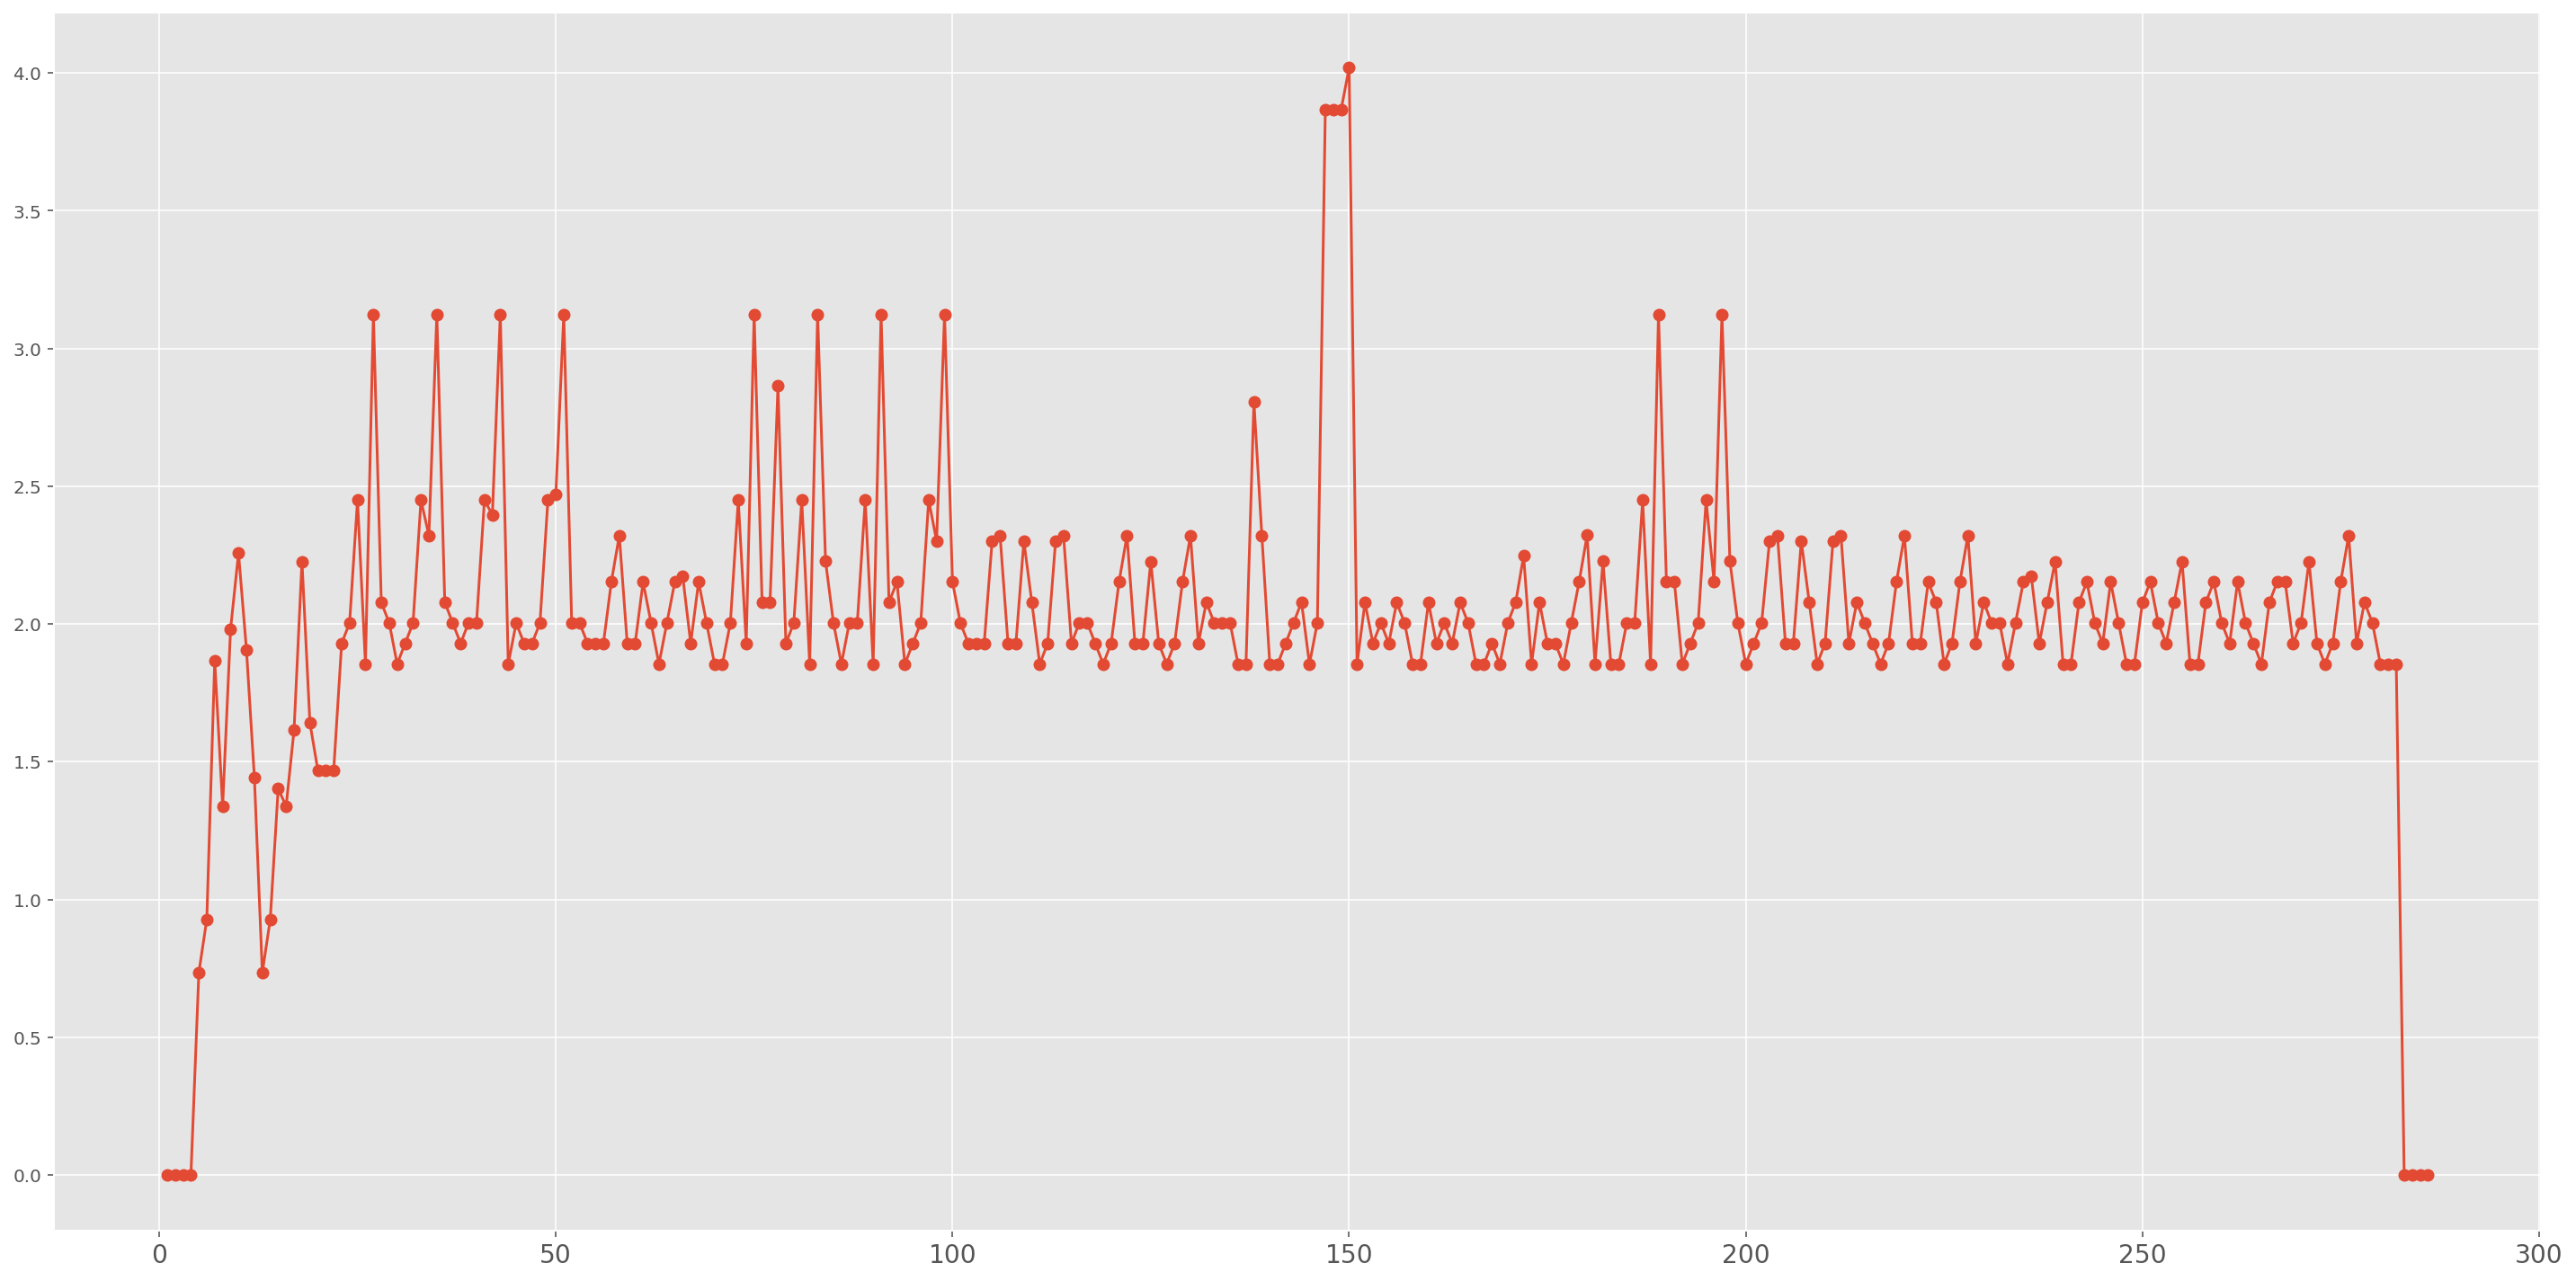

In [32]:
draw_tension(np.arange(diameter.shape[0]) + 1,diameter)

xlabel is time (s)

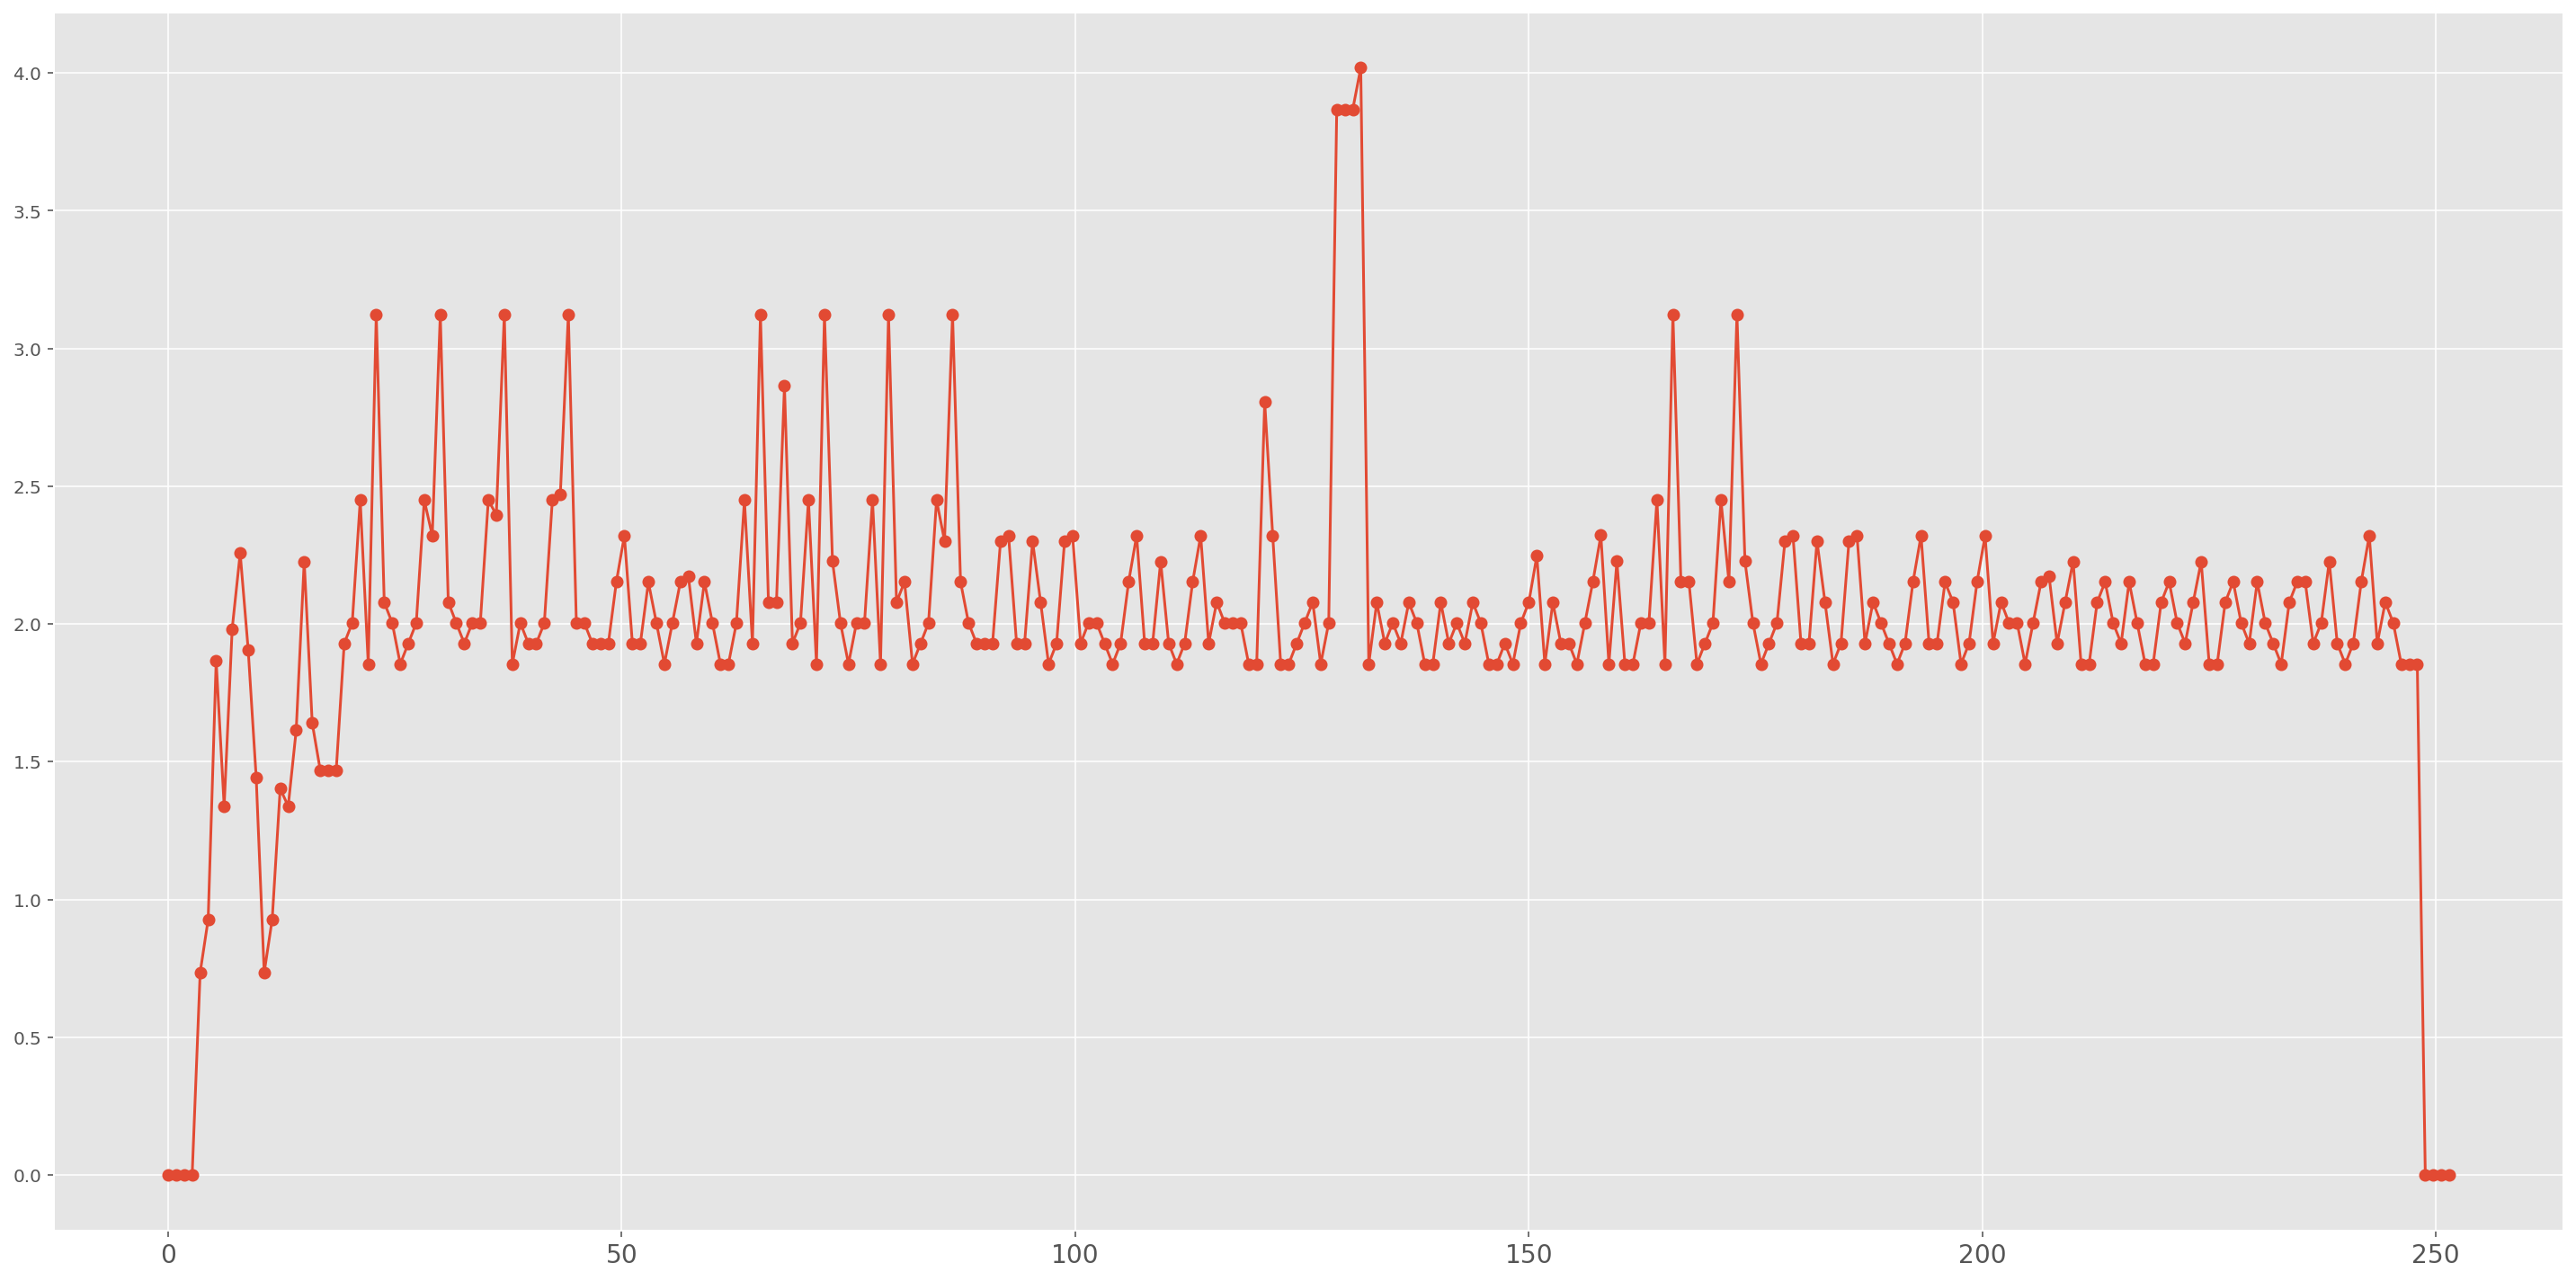

In [33]:
draw_tension(times[:len(diameter)],diameter)

## tensile strain output for bar/time x axis

In [34]:
tensile = pickle.load(open('example/output/55269aebbc2e7784ca2d1d4472141889.tensile','rb'))


In [35]:
print(f'the max tensile strain is located at bar {np.argmax(tensile) + 1} ')

the max tensile strain is located at bar 137 


x label is bar

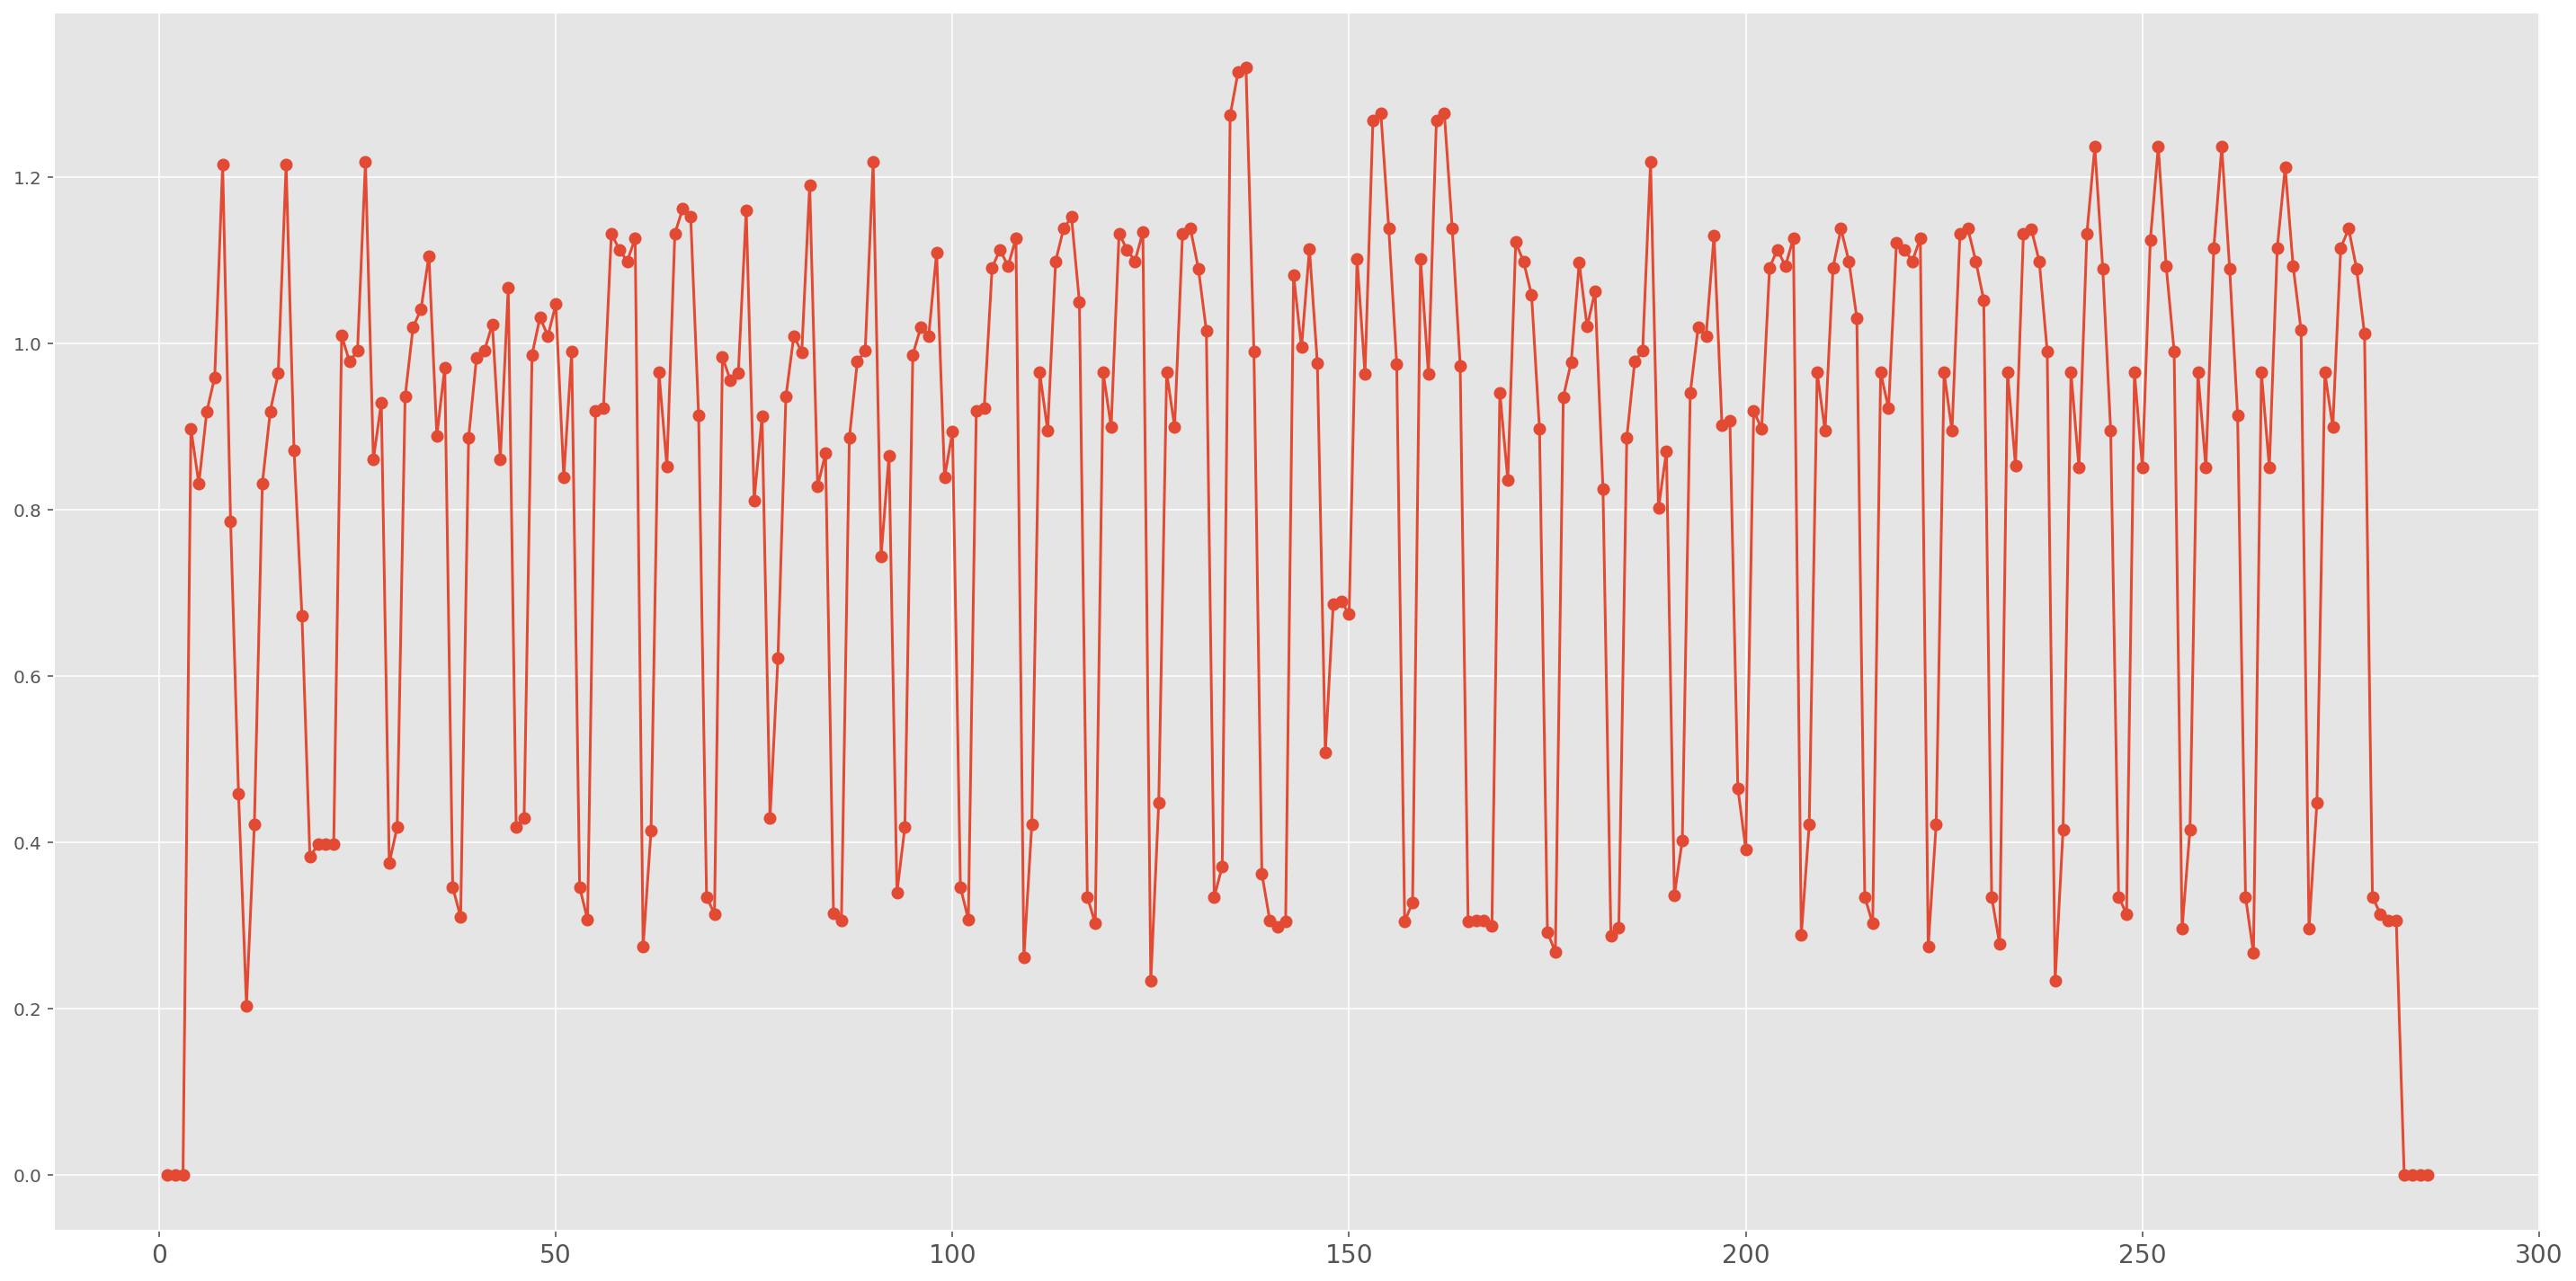

In [36]:
draw_tension(np.arange(tensile.shape[0]) + 1,tensile)

xlabel is time (s)

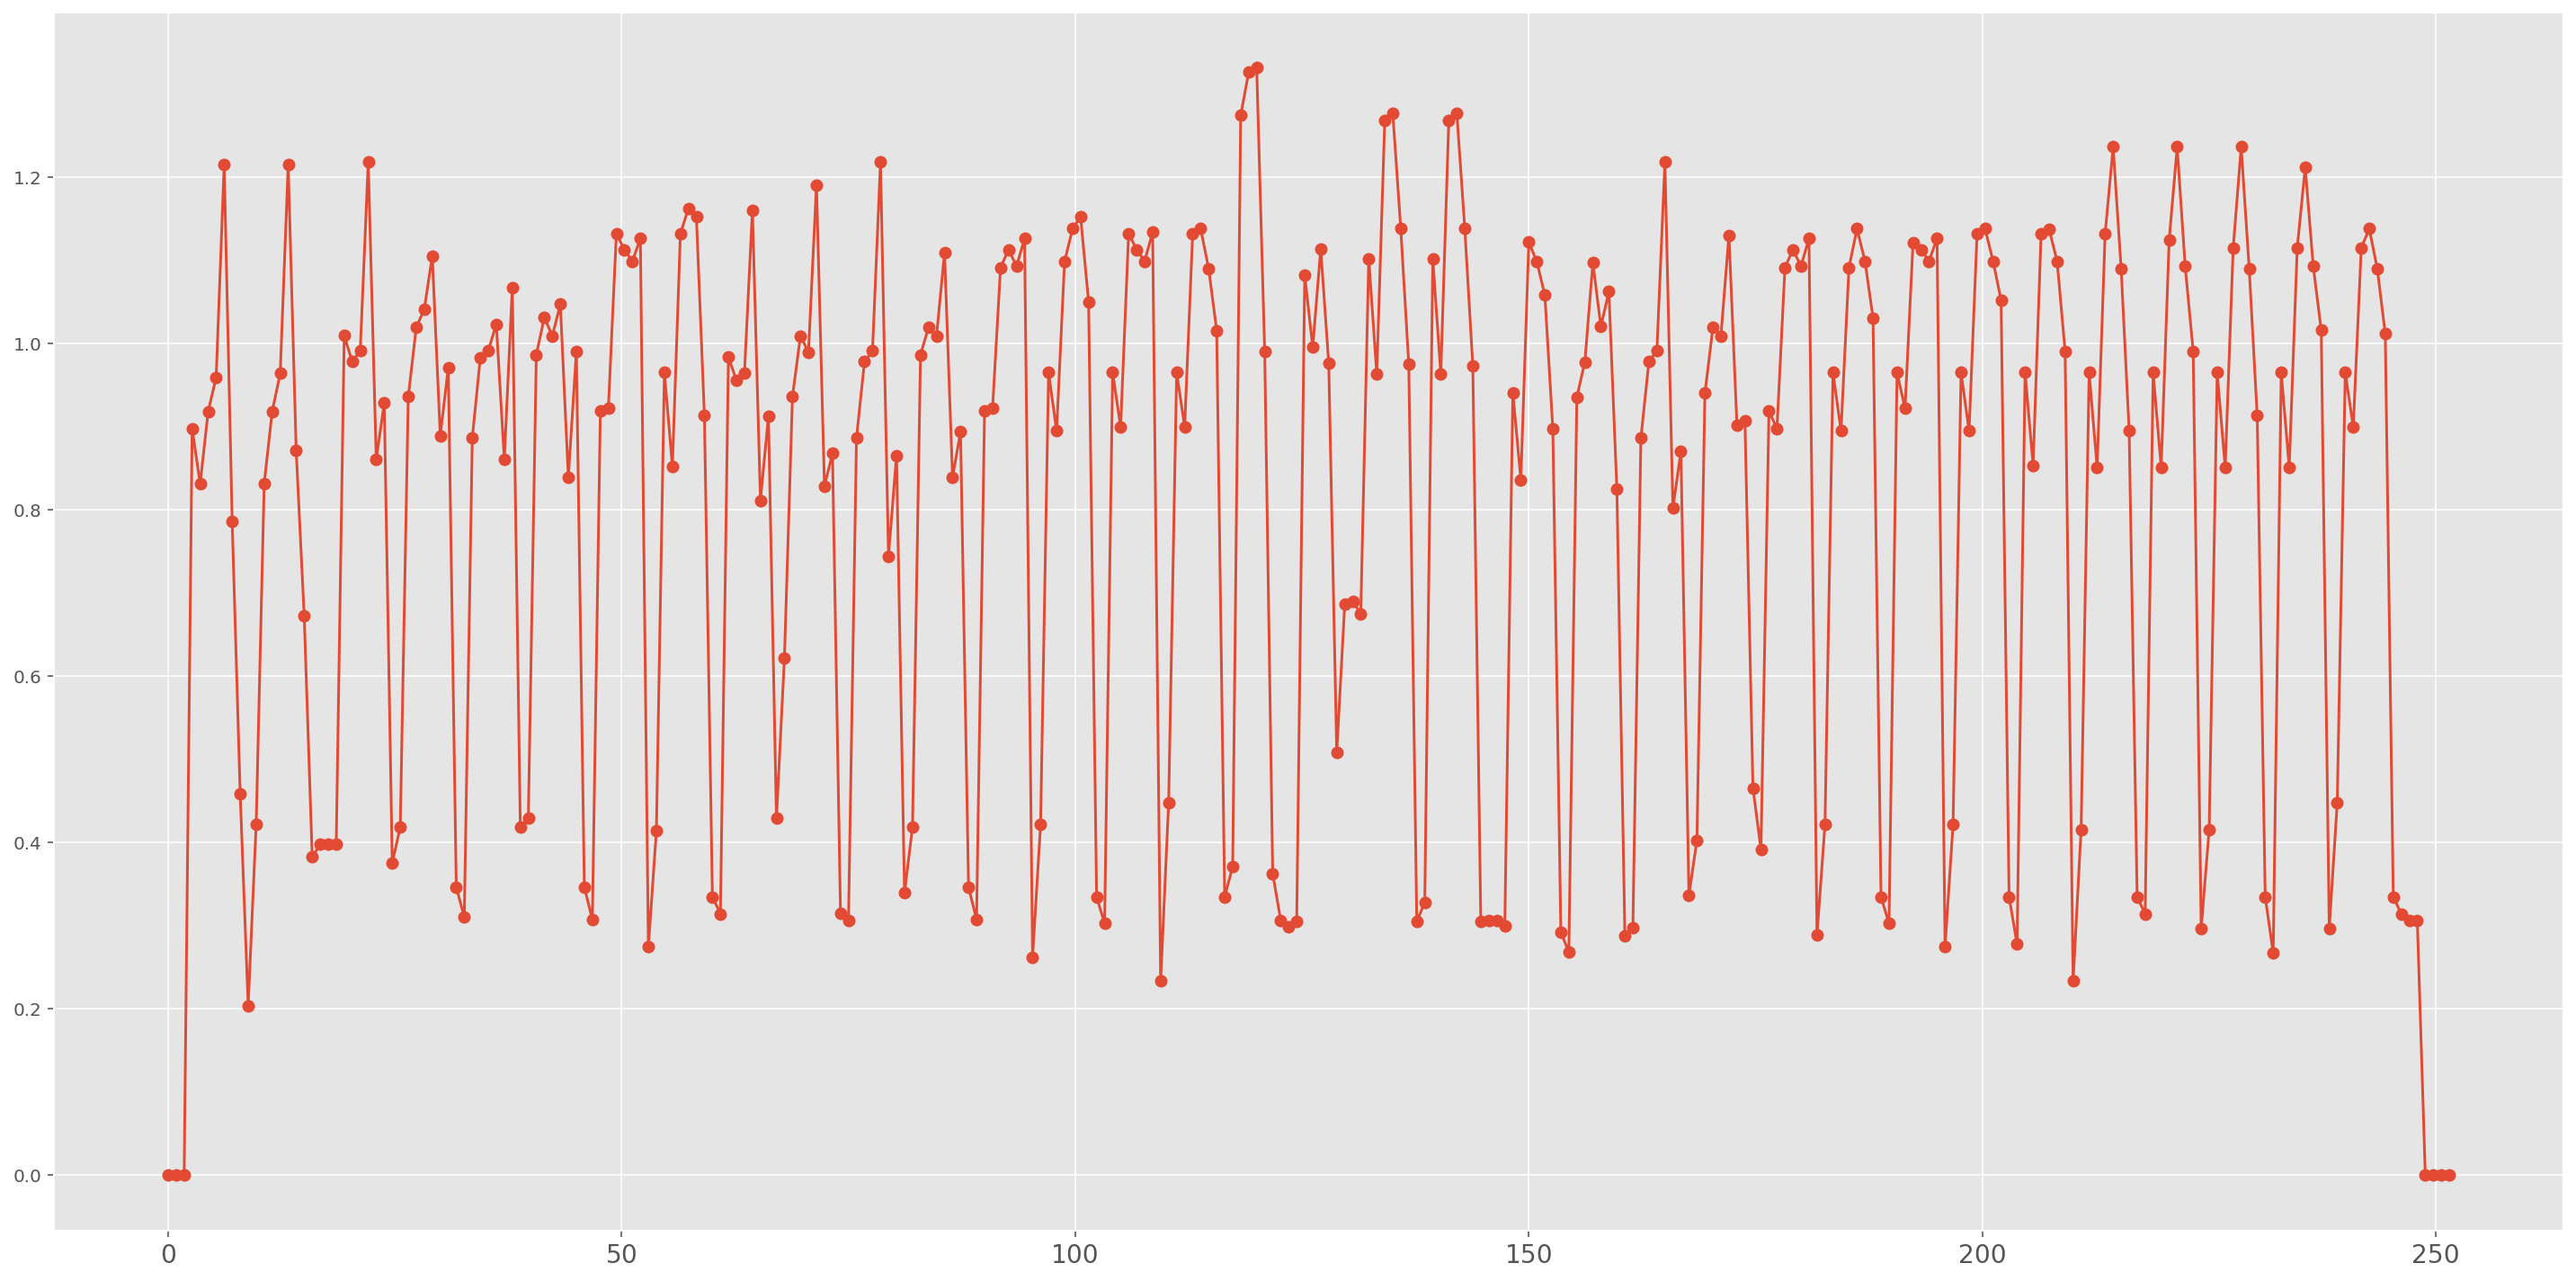

In [37]:
draw_tension(times[:len(tensile)],tensile)

## centroid difference output for bar/time x axis

In [38]:
centroid_diff = pickle.load(open('example/output/55269aebbc2e7784ca2d1d4472141889.centroid_diff','rb'))


In [39]:
print(f'the max centroid difference is located at bar {np.argmax(centroid_diff) + 1} ')

the max centroid difference is located at bar 7 


x label is bar

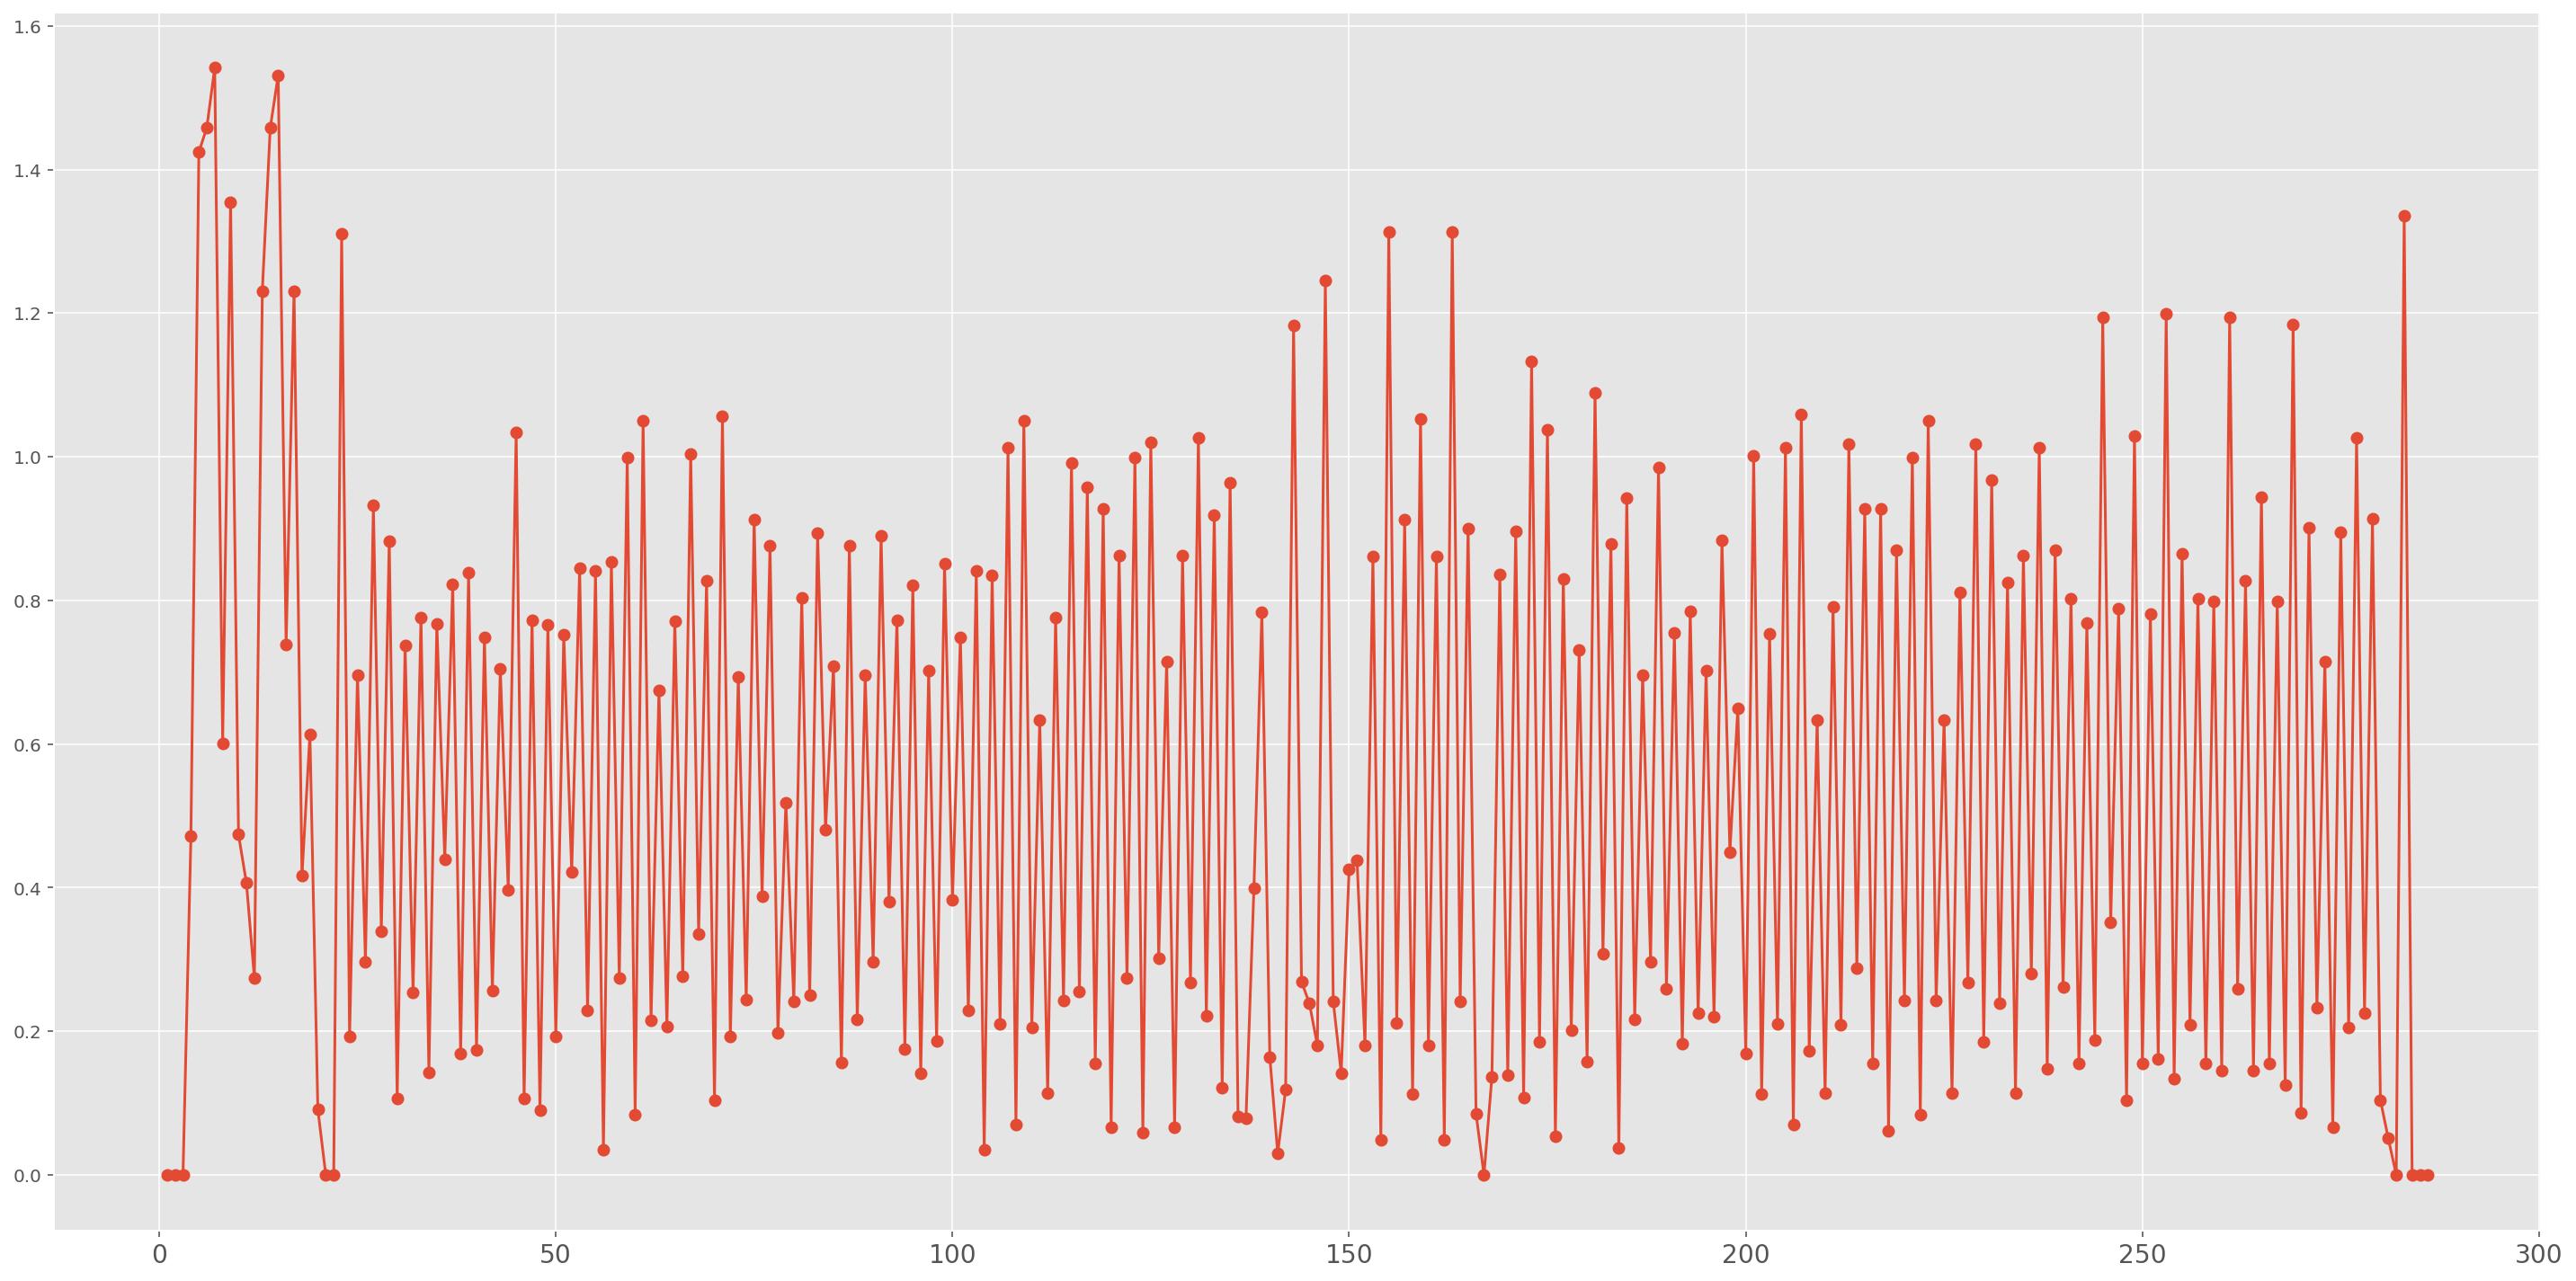

In [40]:
draw_tension(np.arange(centroid_diff.shape[0])+1,centroid_diff)

xlabel is time (s)

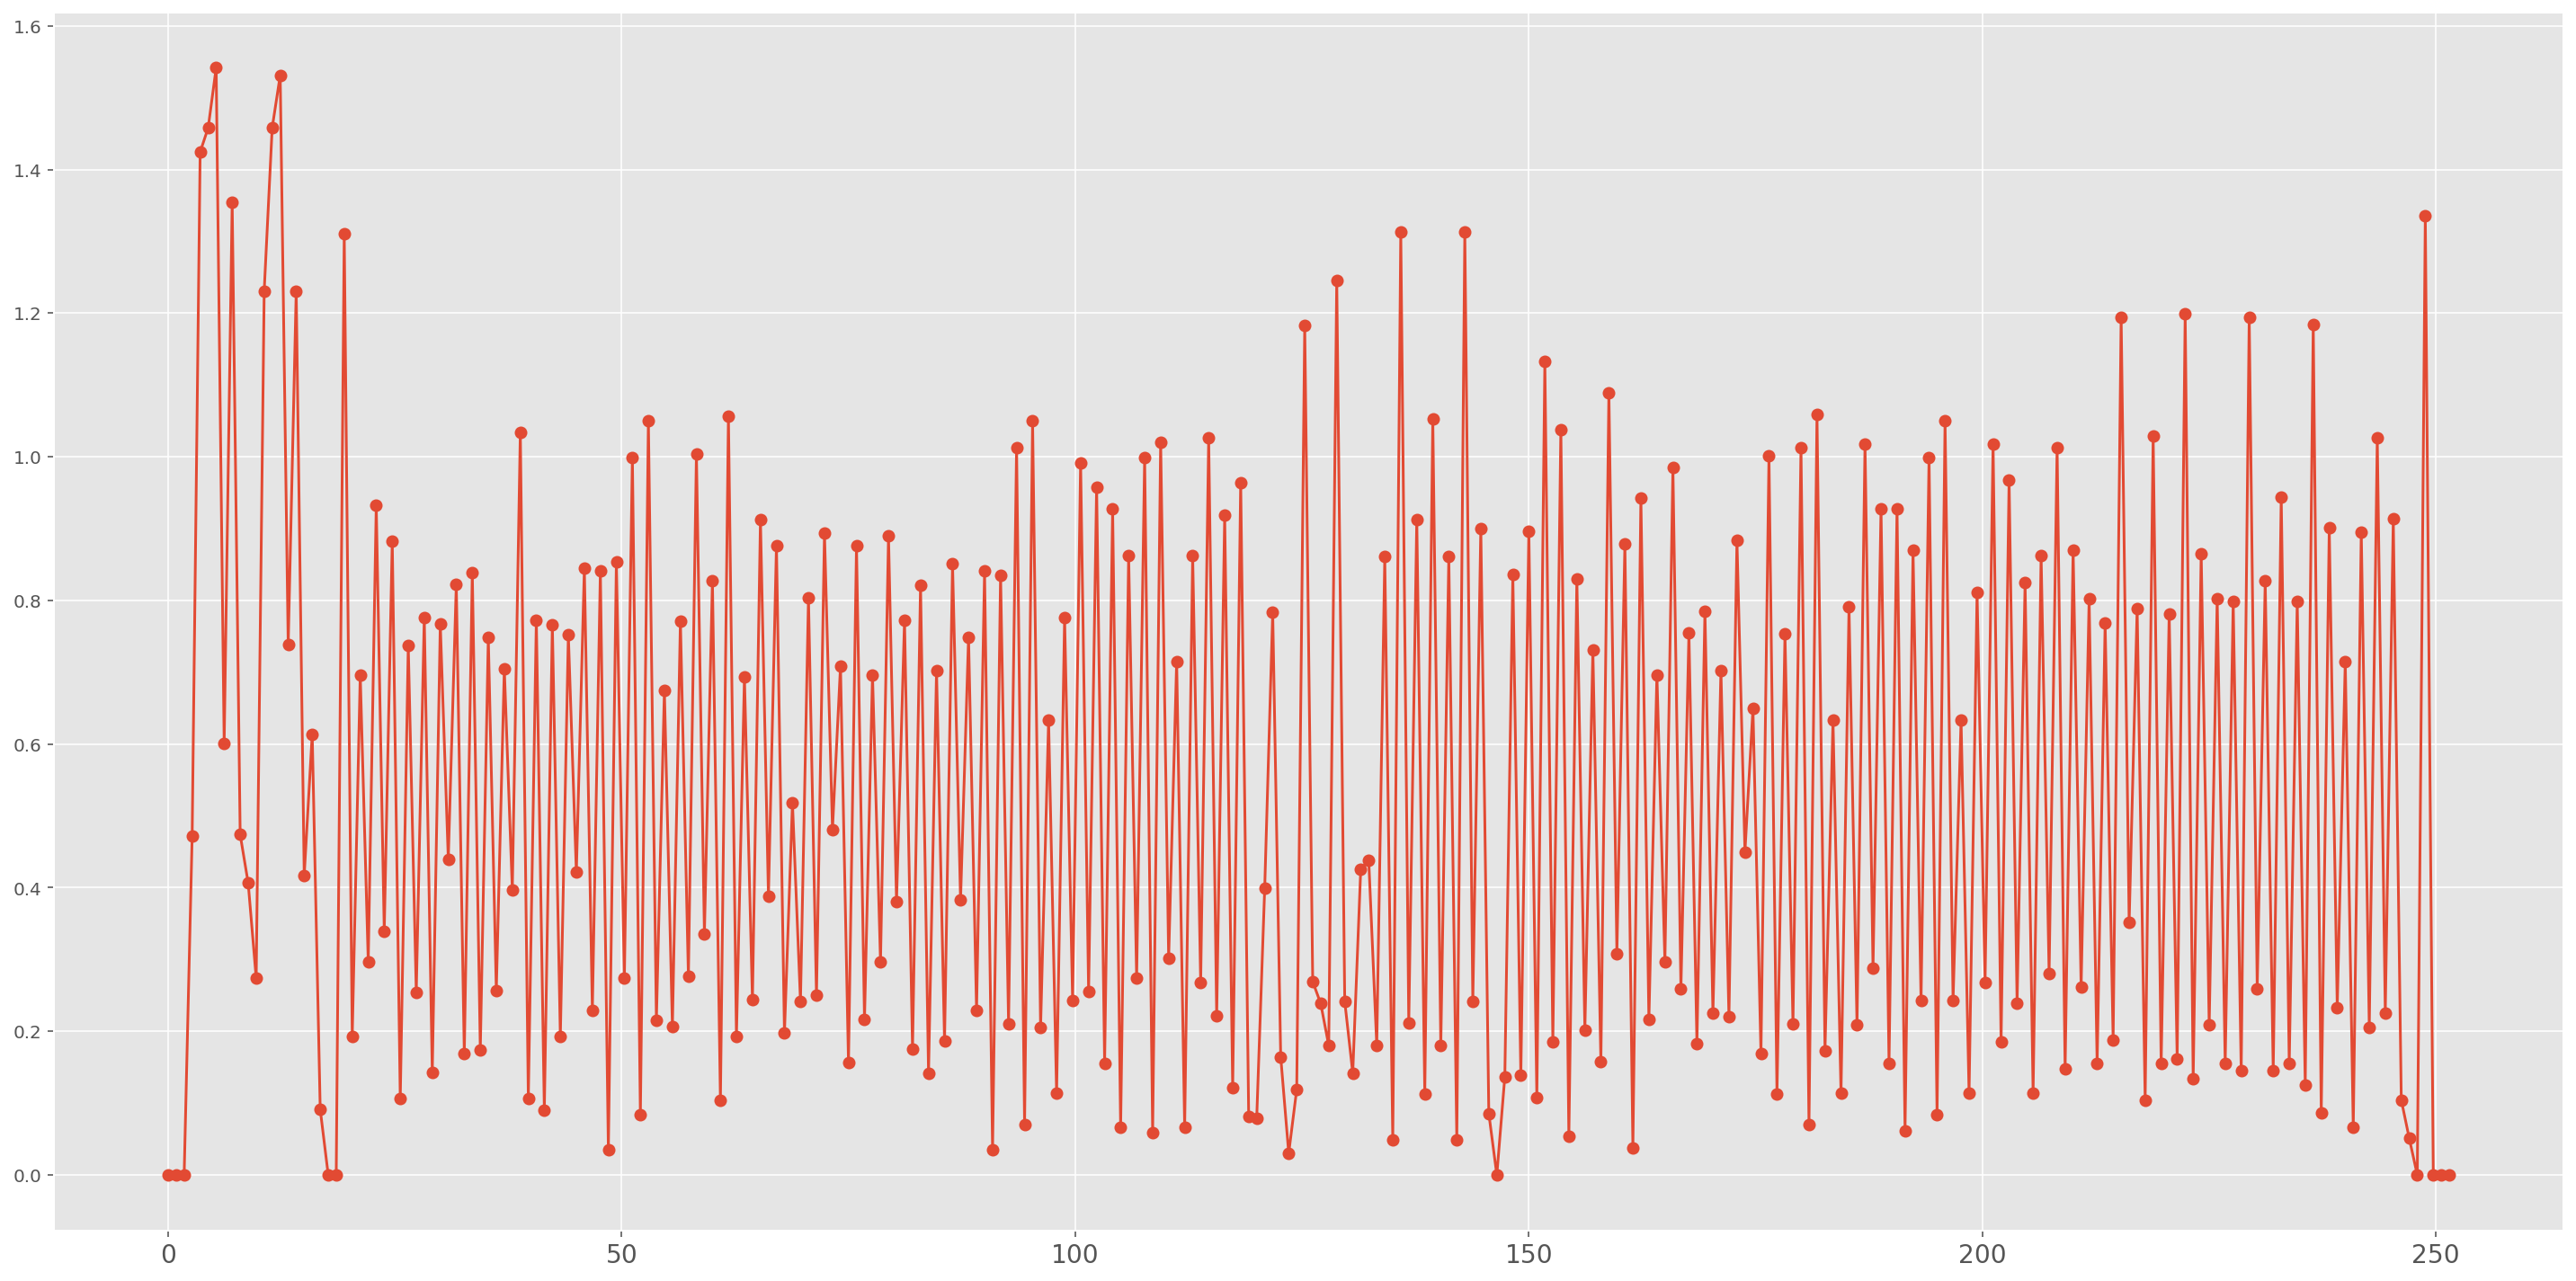

In [41]:
draw_tension(times[:len(centroid_diff)],centroid_diff)

In [42]:
with open(os.path.join('example/output','files_result.json'), 'r') as fp:
    keys = json.load(fp)

In [43]:
for key in keys.keys():
    print(f'song name is {key}')
    print(f'song key is {keys[key][0]}')
    print(f'song key change time {keys[key][1]}')
    print(f'song key change bar {keys[key][2]}')
    print(f'song key change name {keys[key][3]}')
    
    
        

song name is /home/ruiguo/midi-miner/example/output/55269aebbc2e7784ca2d1d4472141889.mid
song key is a minor
song key change time -1
song key change bar -1
song key change name 


-1 change time(or bar) means key no change